
# Proyecto 1
#### Cristina Bautista - 161260
#### Abril Palencia - 18198 

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
# from pandas_profiling import ProfileReport
import re


%matplotlib inline

In [38]:
df1 = pd.read_csv('dataset/dataset-part1.csv')
df2 = pd.read_csv('dataset/dataset-part2.csv')
df3 = pd.read_csv('dataset/dataset-part3.csv')
df4 = pd.read_csv('dataset/dataset-part4.csv')

In [39]:
df_final = pd.concat([df1, df2, df3, df4])

In [40]:
df_final = df_final.drop(labels=['FIREWALL_EVENT', 'FLOW_ACTIVE_TIMEOUT', 'FLOW_DURATION_MICROSECONDS', 'FLOW_END_SEC', 
                          'FLOW_INACTIVE_TIMEOUT', 'FLOW_START_SEC', 'FRAME_LENGTH', 'IPV4_DST_ADDR', 
                          'IPV4_SRC_ADDR', 'MAX_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'MIN_IP_PKT_LEN', 'PROTOCOL_MAP', 
                          'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_BYTES', 
                          'RETRANSMITTED_OUT_PKTS', 'DST_TO_SRC_SECOND_BYTES', 'SRC_TO_DST_SECOND_BYTES', 
                          'L7_PROTO_NAME'], axis=1)

In [41]:
df_final_prueba = df_final.sample(n = 1000000)

In [42]:
df_final_prueba['LABEL'].value_counts()

Normal flow                       841941
SYN Scan - aggressive              62125
Denial of Service R-U-Dead-Yet     56618
Denial of Service Slowloris        21484
UDP Scan                           17261
NULL Scan                            218
XMAS Scan                            185
FIN Scan                             168
Name: LABEL, dtype: int64

In [43]:
valores = ['UDP Scan', 'NULL Scan', 'XMAS Scan', 'FIN Scan']

In [44]:
df_final_prueba = df_final_prueba[df_final_prueba['LABEL'].isin(valores) == False]

In [45]:
valores2 = [47, 58]

In [46]:
df_final_prueba = df_final_prueba[df_final_prueba['PROTOCOL'].isin(valores2) == False]

In [47]:
df_final_prueba['LABEL'].value_counts()

Normal flow                       841909
SYN Scan - aggressive              62125
Denial of Service R-U-Dead-Yet     56618
Denial of Service Slowloris        21484
Name: LABEL, dtype: int64

In [48]:
df_final_prueba['LABEL'].replace({"Normal flow": 0, "Denial of Service R-U-Dead-Yet": 1,
                          "Denial of Service Slowloris": 2, "SYN Scan - aggressive": 3}, inplace=True)

In [49]:
# slowloris = df_final_prueba[df_final_prueba['LABEL'] == 2]
# denial_dead = df_final_prueba[df_final_prueba['LABEL'] == 1]

In [50]:
from imblearn import over_sampling
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

In [51]:
sorted(Counter(df_final_prueba['LABEL']).items())

[(0, 841909), (1, 56618), (2, 21484), (3, 62125)]

0    841909
3     62125
1     56618
2     21484
Name: LABEL, dtype: int64

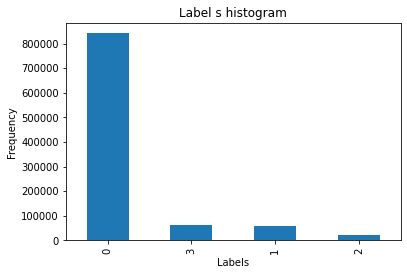

In [52]:
pd.value_counts(df_final_prueba['LABEL']).plot.bar()
plt.title('Label s histogram')
plt.xlabel('Labels')
plt.ylabel('Frequency')
df_final_prueba['LABEL'].value_counts()

In [53]:
X = df_final_prueba
y = df_final_prueba[['LABEL']]
X = X.drop(['LABEL'], axis=1)

In [54]:
# y = pd.DataFrame(y)

In [55]:
y.value_counts()

LABEL
0        841909
3         62125
1         56618
2         21484
dtype: int64

In [56]:
X.shape, y.shape#y.reshape(-1,1)

((982136, 30), (982136, 1))

In [57]:
ros = RandomOverSampler(random_state=5)
X_resample, y_resample = ros.fit_resample(X, y)

In [58]:
y_resample.value_counts()

LABEL
0        841909
1        841909
2        841909
3        841909
dtype: int64

In [59]:
from sklearn.model_selection import train_test_split

In [61]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_resample, y_resample, train_size = 0.55, 
                                                             test_size=0.45, random_state = 0)

In [62]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size = 0.67, 
                                                             test_size=0.33, random_state = 0)

In [63]:
from sklearn.tree import DecisionTreeClassifier

In [64]:
dTree = DecisionTreeClassifier()

In [65]:
dTree = dTree.fit(X_train, y_train)

In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [67]:
target_prediction = dTree.predict(X_val)

In [68]:
accuracy_score(y_val, target_prediction)

0.999992120881437

In [69]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 982136 entries, 11190856 to 12771682
Data columns (total 30 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   BIFLOW_DIRECTION            982136 non-null  int64
 1   DIRECTION                   982136 non-null  int64
 2   FIRST_SWITCHED              982136 non-null  int64
 3   FLOW_DURATION_MILLISECONDS  982136 non-null  int64
 4   FLOW_END_MILLISECONDS       982136 non-null  int64
 5   FLOW_ID                     982136 non-null  int64
 6   FLOW_START_MILLISECONDS     982136 non-null  int64
 7   IN_BYTES                    982136 non-null  int64
 8   IN_PKTS                     982136 non-null  int64
 9   L4_DST_PORT                 982136 non-null  int64
 10  L4_SRC_PORT                 982136 non-null  int64
 11  LAST_SWITCHED               982136 non-null  int64
 12  OOORDER_IN_PKTS             982136 non-null  int64
 13  OOORDER_OUT_PKTS            982136 

In [70]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 982136 entries, 11190856 to 12771682
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   LABEL   982136 non-null  int64
dtypes: int64(1)
memory usage: 15.0 MB


In [71]:
confusion_matrix(y_val, target_prediction)

array([[254463,      1,      1,      6],
       [     0, 252909,      0,      0],
       [     0,      0, 253769,      0],
       [     0,      0,      0, 254193]])

In [76]:
target_names=[0, 1, 2, 3]
target_names=list(map(str,target_names))

In [77]:
print(classification_report(y_val, target_prediction, target_names=target_names))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    254471
           1       1.00      1.00      1.00    252909
           2       1.00      1.00      1.00    253769
           3       1.00      1.00      1.00    254193

    accuracy                           1.00   1015342
   macro avg       1.00      1.00      1.00   1015342
weighted avg       1.00      1.00      1.00   1015342

